# use pmcx to fit the coefficient of the noabs data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pmcx
from scipy.optimize import curve_fit
from cv2 import resize
from scipy.signal import fftconvolve
import cv2

IRF = np.load(r'IRF_gain0.7_timebin15ps_2000bins_061224.npy')[:1000]
IRF = IRF - IRF[:100].mean()        # get rid of dark count
IRF = IRF/IRF.max()
irf_down = resize(IRF[:np.round(121*(100/15)).astype('int')], (1, 121), interpolation=cv2.INTER_NEAREST_EXACT)
irf_down = np.squeeze(irf_down)     # get rid of extra dimension

noabs = np.load(r'noabs1_gain0.7_5x5cm_31x31points_pol50deg_expo1.0sec_binWidth15ps_binNum2000_061224.npy')[:,:,:1000]
X,Y = np.meshgrid([0,15,30], [0,15,30])
no_abs = noabs[X,Y]
no_abs_down = np.zeros((3, 3, 121))
for i in range(3):
    for j in range(3):
        no_abs_down[i,j] = np.squeeze(resize(no_abs[i,j,:np.round(121*(100/15)).astype('int')], (1, 121), 
                                             interpolation=cv2.INTER_NEAREST_EXACT))

no_abs_down = no_abs_down/no_abs_down.max()                 # normalize
fit_weight = (no_abs_down/no_abs_down.max()).max(axis = 2)  # get the weight for fitting

## prepare the params for pmcx

In [18]:
thickness = 50 # mm
unitinmm = 1
t_vox = int(thickness/unitinmm)
vol = np.ones([250,250,t_vox+1],dtype='uint8')
vol[:,:,-1] = 0                                 # boundary voxel

cfg = {'nphoton': 1e7, 
       'vol': vol, 
       'tstart':0, 
        'tend':12.1e-9, 
        'tstep':0.1e-9,  # 100ps resolution
       'srcpos': [125,125,0], 
       'srcdir':[0,0,1],
       'unitinmm':unitinmm,
       'detpos': [125, 125, t_vox, 4], #radius approx 1mm (4vox) (fibre ~2mm from sample)
       'issrcfrom0':1,
       'issavedet':1,
       'issaveref':1
       }

sensitivity = np.load('sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy').sum(2)
sensitivity = sensitivity/sensitivity.max()
sensitivity = np.fliplr(sensitivity)                # flip to match the PMT view
sensitivity = resize(sensitivity, (80,80), interpolation=cv2.INTER_LINEAR)
sens = np.zeros((250,250))
sens[125-40:125+40, 125-40:125+40] = sensitivity

def simfn(cfg, mu_a, mu_s):
    cfg['prop'] = [[0,0,1,1],           # background
                   [mu_a,mu_s,0,1.44]   # volume 1
                   ]
    
    return pmcx.run(cfg)   # pmcx.mcxlab calls pmcx.run, and postprocess res['detp'] and res['traj'] raw data into dict form

def fitfn(cfg, mu_a, mu_s):
    sim_3x3 = np.zeros((3,3,121))
    for i, posy in enumerate([150, 125, 100]):
        for j, posx in enumerate([150, 125, 100]):
            cfg['srcpos'] = [posx, posy, 0]
            print(cfg['srcpos'])
            
            res = simfn(cfg, mu_a, mu_s)
            
            #==============retrieve the results via surface fluence===================
            dref_bd = res['dref'][:,:,int(vol.shape[2]-1),:]            # get the boundary value
            dref_bd_rot = np.rot90(dref_bd, k=1, axes = (0,1))          # rotate the output to get correct angle
            sim_3x3[i, j] = (dref_bd_rot*sens[:,:,None]).sum((0,1))     # only obtain the time trace
            
            print(f'mua = {mu_a}\nmus = {mu_s}')
    sim_3x3 = np.apply_along_axis(lambda m: fftconvolve(m, irf_down, mode='full'), axis=2, arr=sim_3x3)[:,:,:len(irf_down)]
    sim_3x3 = sim_3x3/sim_3x3.max()   # normalize
    return (sim_3x3/fit_weight[:,:,None]).flatten()     # apply weight for fitting

## run the pmcx fitting

In [19]:
print('fitting..\n#######################')
y = no_abs_down
y = y/y.max()
y = y/fit_weight[:,:,None]

p, pcov = curve_fit(fitfn,
                    cfg,
                    y.flatten(),
                    p0=[0.0025883,1.68196508], 
                    # bounds=([0.0001,0.5],[0.1, 2]),
                    # epsfcn=1e-5,
                    ftol=1e-5,
                    method = 'trf'
                    )
print('..fitted\n#######################')
print(f'p = {p}')

fit_sim = fitfn(cfg,*p)

fitting..
#######################
[150, 150, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1
mua = 0.0025883
mus = 1.68196508
[125, 150, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1
mua = 0.0025883
mus = 1.68196508
[100, 150, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1
mua = 0.0025883
mus = 1.68196508
[150, 125, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1
mua = 0.0025883
mus = 1.68196508
[125, 125, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1
mua = 0.0025883
mus = 1.68196508
[100, 125, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1
mua = 0.0025883
mus = 1.68196508
[150, 100, 0]
nphoton: 1e+07
tstart: 0
tstep: 1e-10
te

## compare the fit result with exp

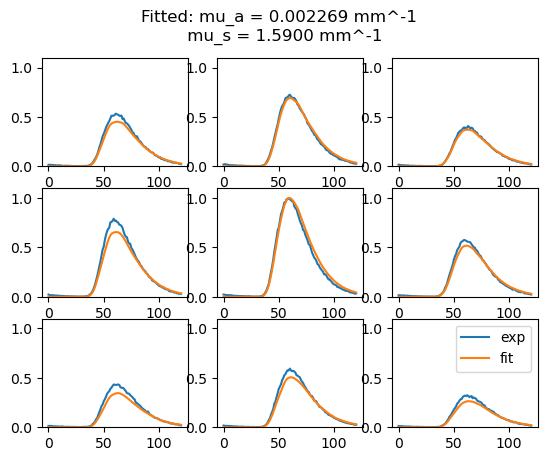

In [24]:
y = no_abs_down
y = y/y.max()
plt.figure()
# plt.title(r'mu_a = 0.0019,mu_s = 1.48')
fit_sim = np.reshape(fit_sim,y.shape)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(3,3,3*i+j+1)
        plt.plot(y[i,j,:], label='exp')
        plt.plot(fit_sim[i,j,:]*fit_weight[i,j], label='fit')
        plt.ylim([0,1.1])
plt.suptitle(f'Fitted: mu_a = {p[0]:.6f} mm^-1 \n mu_s = {p[1]:.4f} mm^-1')
plt.legend()
plt.show()
